In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numba import jit
import pstats
import heapq
import time
import cProfile
import pandas as pd

In [2]:
puzzle_info_path = 'puzzle_info.csv'
puzzles_path = 'puzzles.csv'
sample_submission_path = 'sample_submission.csv' # change name across board
puzzle_info_df = pd.read_csv(puzzle_info_path)
puzzles_df = pd.read_csv(puzzles_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [3]:
puzzles_df['parsed_initial_state'] = puzzles_df['initial_state'].apply(lambda x: x.split(';'))
seen = {}

for i in range(len(puzzles_df['parsed_initial_state'])):
    for j in range(len(puzzles_df['parsed_initial_state'][i])):
        if puzzles_df['parsed_initial_state'][i][j] not in seen:
            seen[puzzles_df['parsed_initial_state'][i][j]] = len(seen)
        puzzles_df['parsed_initial_state'][i][j] = seen[puzzles_df['parsed_initial_state'][i][j]]

puzzles_df['parsed_solution_state'] = puzzles_df['solution_state'].apply(lambda x: x.split(';'))

for i in range(len(puzzles_df['parsed_solution_state'])):
    for j in range(len(puzzles_df['parsed_solution_state'][i])):
        puzzles_df['parsed_solution_state'][i][j] = seen[puzzles_df['parsed_solution_state'][i][j]]

In [4]:
import json

# Converting the string representation of allowed_moves to dictionary
puzzle_info_df['allowed_moves'] = puzzle_info_df['allowed_moves'].apply(lambda x: json.loads(x.replace("'", '"')))

# Selecting an example puzzle type and displaying its allowed moves
example_puzzle_type = puzzle_info_df['puzzle_type'].iloc[0]
example_allowed_moves = puzzle_info_df[puzzle_info_df['puzzle_type'] == example_puzzle_type]['allowed_moves'].iloc[0]

def getInversePerm(arr):
    # gets the inverse move for a certain move
    res = [0 for i in range(len(arr))]
    for i in range(len(arr)):
        res[arr[i]] = i
    return res
    
# type : (np.array(move_perm_i), np.array(name_i))
puz_info = {}

# type : {move : perm}
move_to_perm = {}

for i in range(len(puzzle_info_df)):
    puz_info[puzzle_info_df['puzzle_type'][i]] = [[], []]
    move_to_perm[puzzle_info_df['puzzle_type'][i]] = {}
    
    for j in puzzle_info_df['allowed_moves'][i].keys():
        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(j)
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(puzzle_info_df['allowed_moves'][i][j]))

        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(str('-' + j)) # might be the opposite
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j])))

        move_to_perm[puzzle_info_df['puzzle_type'][i]][str('-' + j)] = np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j]))
        move_to_perm[puzzle_info_df['puzzle_type'][i]][j] = np.array(puzzle_info_df['allowed_moves'][i][j])

In [5]:
N = 2
M = 16

In [6]:
@jit(nopython=True, fastmath = True)
def hash_perm(perm):
    base = 9973
    modb = 1000000007
    modc = 1000000009

    B, C = 0, 0
    for i in perm:
        B = (B * base) % modb + i
        C = (C * base) % modc + i

    return (B, C)

# improve the a
@jit(nopython=True,fastmath = True)
def dist(a):
    res = 0
    for i in range(M):
        if (a[i] >= M):
            cur = abs(i + M - a[i])
            res += max(0, min(cur, M - cur) - 8)
        else:
            cur = abs(i - a[i])
            res += min(cur, M - cur)

    for i in range(M):
        if (a[i + M] < M):
            cur = abs(i - a[i + M])
            res += max(0, min(cur, M - cur) - 8)
        else:
            cur = abs(i + M - a[i + M])
            res += min(cur, M - cur)

    return res / 32

In [7]:
# 1e6 ~ 2 seconds
mx_mem = int(1e7)
mem_idx = 0

last_state = np.zeros(mx_mem, dtype=int)
last_move = np.zeros(mx_mem, dtype=int)

print(last_state)

[0 0 0 ... 0 0 0]


In [19]:
pq = []
improvements = []

def a_star_search(move_perm, initial_state, goal_state):
    global mem_idx
    
    max_dist = 0

    n = len(initial_state)
    m = len(move_perm)

    print(n, m)

    avg_dist = np.array([n + 1 for i in range(500 * n)], dtype = np.float32)
    n_dist = np.array([0 for i in range(500 * n)])

    def upd_prune(nxt_p, nxt_dist):
        if n_dist[nxt_p] == 0:
            avg_dist[nxt_p] = nxt_dist
            n_dist[nxt_p] = 1
            return True

        if n_dist[nxt_p] > 500:
            if nxt_dist > avg_dist[nxt_p]:
                return False
        avg_dist[nxt_p] *= n_dist[nxt_p] / (n_dist[nxt_p] + 1)
        avg_dist[nxt_p] += nxt_dist / (n_dist[nxt_p] + 1)
        n_dist[nxt_p] += 1
        return True
    mx_len = 0
    heapq.heappush(pq, (0, mem_idx, initial_state, 0))  # (priority, mem_idx, state, path_length)
    mem_idx += 1

    pruned_branch = 0
    
    best_so_far = 1e18
    S = time.time()
    considered = set()
    considered.add(hash_perm(initial_state))
    while mem_idx + m < mx_mem:
        cur_p_plus_dist, cur_idx, cur_state, cur_p = heapq.heappop(pq) 
        cur_dist = cur_p_plus_dist - cur_p
        
        # if mx_len > 50 and np.random.rand() > 1 + cur_p / mx_len - 0.3: # Pruning 2 (too risky) --> missing results in HUGE penalty
        #     pruned_branch += 1
        #     continue

        mx_len = max(mx_len, cur_p + 1)

        
        for i in range(m):
            nxt_state = cur_state[move_perm[i]]
            nxt_hash = hash_perm(nxt_state)
            nxt_p = 1 + cur_p

            nxt_dist = dist(nxt_state)
            

            ok = upd_prune(nxt_p, nxt_dist)
            if not ok:
                pruned_branch += 1
                continue

            
            if nxt_hash in considered:
                continue
            considered.add(nxt_hash)

            if nxt_dist < best_so_far:
                improvements.append((time.time() - S, nxt_dist))
                print(nxt_dist)
                best_so_far = nxt_dist
            
            last_state[mem_idx] = cur_idx
            last_move[mem_idx] = i

            if np.array_equal(nxt_state, goal_state):
                print("Number of pruned branches", pruned_branch)
                print("Final length", cur_p)
                print("Final Dist", nxt_dist)
                
                return mem_idx
            
            priority = nxt_p + nxt_dist
            heapq.heappush(pq, (priority, mem_idx, nxt_state, 1+cur_p))
            mem_idx += 1
    return None

initial_state = np.array([26,
 10,
 17,
 24,
 11,
 3,
 14,
 16,
 23,
 2,
 21,
 1,
 25,
 22,
 27,
 9,
 7,
 6,
 8,
 5,
 19,
 0,
 31,
 12,
 30,
 18,
 15,
 28,
 13,
 20,
 4,
 29])

goal_state = np.array([i for i in range(32)])
move_perm = [np.array(move_to_perm['globe_1/8']['r0']), np.array(move_to_perm['globe_1/8']['r1']), np.array(move_to_perm['globe_1/8']['f0'])]

In [21]:
%%time
a_star_search(move_perm, initial_state, goal_state)

32 3
2.21875
1.96875
1.8125
1.75
1.625
1.53125
1.5
1.40625
1.3125
1.21875
1.09375
1.03125
0.90625
0.875
0.84375
0.8125
0.78125
0.75
0.6875
0.65625
0.625
0.59375
0.5625
0.53125
0.5
0.4375
0.375
0.34375
0.3125
0.28125
0.21875
0.1875
0.09375
0.0625
CPU times: user 1min 1s, sys: 1.15 s, total: 1min 2s
Wall time: 1min 4s


In [ ]:
print(len(pq))

fringe_lengths = [] # all path lengths on fringe
for j in pq:
    fringe_lengths.append(j[3])

plt.hist(fringe_lengths)

In [ ]:
print("For path length 10, distribution of distances")
print(len(test10))
temp = []
for i in test10:
    temp.append(i[0])
plt.hist(temp)

For path length 10, distribution of times (where we changed the average)
6022


(array([ 669.,  803.,  827., 1034.,  658.,  469.,  625.,  406.,  310.,
         221.]),
 array([  818. ,  5850.1, 10882.2, 15914.3, 20946.4, 25978.5, 31010.6,
        36042.7, 41074.8, 46106.9, 51139. ]),
 <BarContainer object of 10 artists>)

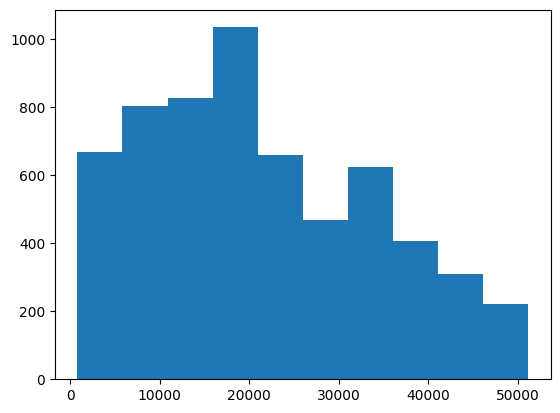

In [246]:
print("For path length 10, distribution of times (where we changed the average)")
print(len(test10))
temp = []
for i in test10:
    temp.append(i[1])
plt.hist(temp)

2418


(array([125., 498., 711., 475., 244.,  71.,  73., 151.,  47.,  23.]),
 array([49129., 51024., 52919., 54814., 56709., 58604., 60499., 62394.,
        64289., 66184., 68079.]),
 <BarContainer object of 10 artists>)

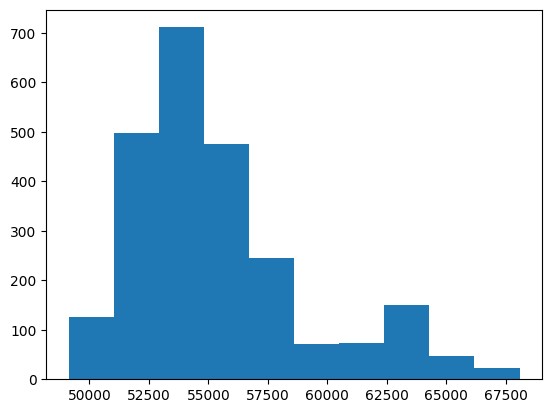

In [247]:
print(len(test30))
temp = []
for i in test30:
    temp.append(i[1])
plt.hist(temp)

In [248]:
print(len(test50))

17


17


(array([2., 1., 3., 1., 2., 1., 2., 1., 2., 2.]),
 array([74857. , 74858.5, 74860. , 74861.5, 74863. , 74864.5, 74866. ,
        74867.5, 74869. , 74870.5, 74872. ]),
 <BarContainer object of 10 artists>)

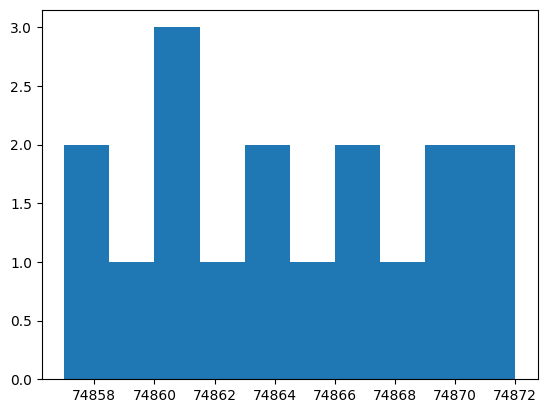

In [249]:
print(len(test50))
temp = []
for i in test50:
    temp.append(i[1])
plt.hist(temp)

In [250]:
print(len(test70))

0


0


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

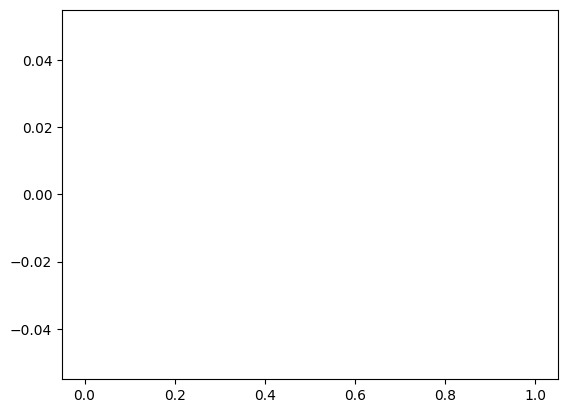

In [251]:
print(len(test70))
temp = []
for i in test70:
    temp.append(i[1])
plt.hist(temp)

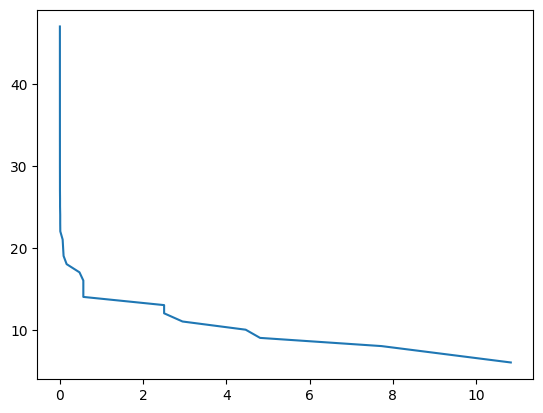

In [255]:

xs = []
ys = []

for i in improvements:
    xs.append(i[0])
    ys.append(i[1])
    
plt.plot(xs, ys)

In [258]:
%%time
def dig_through_memory(idx):
    res = []
    while idx != 0:
        res.append(last_move[idx])
        idx = last_state[idx]

    res = list(reversed(res))
    return res

def solve(idx):
    global mem_idx
    
    mem_idx = 0
    
    move_name = np.array(puz_info[puzzles_df['puzzle_type'][idx]][1])

    res = a_star_search(idx)
    
    if res == None:
        return None

    res = dig_through_memory(res)
    for i in range(len(res)):
        res[i] = move_name[res[i]]

    return res

A = solve(30)
A

42


IndexError: index 44 is out of bounds for axis 0 with size 10

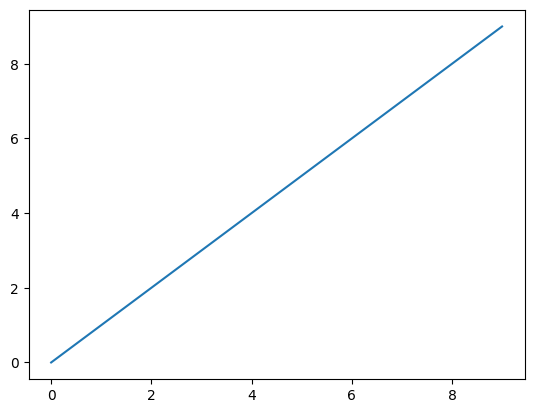

In [15]:

ys = [i for i in range(10)]
plt.plot(xs, ys)

# Step 6: Build submission format function

In [28]:
def format_solution_for_submission(puzzle_id, solution_moves):
    """
    Format the solution to a puzzle for submission.

    :param puzzle_id: The unique identifier of the puzzle.
    :param solution_moves: List of tuples representing the solution moves.
    :return: Formatted string suitable for submission.
    """
    formatted_moves = []
    for move in solution_moves:
        formatted_moves.append(move)

    # Joining the moves into a single string separated by periods
    return {'id': puzzle_id, 'moves': '.'.join(formatted_moves)}


# Step 7: Define solve function

In [29]:
from tqdm import tqdm

all_ok = []
res_df = []

for i in tqdm(range(len(puzzles_df))):
    res = solve(i)
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

  0%|                                                   | 0/398 [00:00<?, ?it/s]

OK : 0 16
num [6, 3]
OK : 1 13131
num [0, 6, 2, 9, 9, 2, 9, 3, 8]


  1%|▎                                          | 3/398 [00:01<03:15,  2.02it/s]

OK : 2 776542
num [3, 5, 1, 7, 1, 8, 7, 9, 0, 8, 8, 1]


  1%|▎                                          | 3/398 [00:02<05:00,  1.31it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(res_df), len(puzzles_df))):
    res = None
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

In [ ]:
print(all_ok)

In [ ]:
res_df = pd.DataFrame(res_df)
res_df

# Step 9: Save submission

In [ ]:
# Define the file path for the output CSV file
output_csv_path = 'submission.csv'

# Save the output DataFrame to a CSV file
res_df.to_csv(output_csv_path, index=False)

# Return the path of the saved file
output_csv_path